In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_preprocessing import get_input_share_tokenizer
from pretrained_embedding import get_input_plus_embedding_vectors_share_tokenizer

from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Dense, Activation, Flatten, Conv1D, MaxPooling1D
from keras.layers import LSTM, Dropout

from tensorflow.keras import regularizers

In [4]:
def create_model(vocabulary_length, max_length_sequence, emb_dim, transfer_learning, embedding_vectors,
                 filters, kernel_size, dense_units, l2_kernel):
    
    X_input = Input(shape = (max_length_sequence, ))
    
    if transfer_learning:
        embedding_layer = Embedding(input_dim = vocabulary_length, output_dim = emb_dim, weights=[embedding_vectors],
                                trainable = False)(X_input)
    else:
        embedding_layer = Embedding(input_dim = vocabulary_length, output_dim = emb_dim,
                                trainable = True)(X_input)
    
    X = Conv1D(filters = filters, kernel_size = kernel_size, activation = 'relu',
              kernel_regularizer = regularizers.l2(l2_kernel))(embedding_layer)
    X = MaxPooling1D(pool_size = 2)(X)
    X = Flatten()(X)
    X = Dense(units = dense_units, activation = 'relu')(X)
    X = Dense(units = 1, activation = 'sigmoid')(X)
                          
    model = Model(inputs = X_input, outputs = X)
                          
    return(model)

In [5]:
def create_model_RNN(vocabulary_length, max_length_sequence, emb_dim, transfer_learning, embedding_vectors, 
                     lstm_units, l2_kernel, l2_recurrent, l2_activity, dropout):
    
    X_input = Input(shape = (max_length_sequence, ))
    
    if transfer_learning:
        embedding_layer = Embedding(input_dim = vocabulary_length, output_dim = emb_dim, weights=[embedding_vectors],
                                trainable = False, mask_zero = True)(X_input)
    else:
        embedding_layer = Embedding(input_dim = vocabulary_length, output_dim = emb_dim,
                                trainable = True, mask_zero = True)(X_input)
    
    X = LSTM(units = lstm_units, return_sequences = False,
            kernel_regularizer = regularizers.l2(l2_kernel),
            recurrent_regularizer = regularizers.l2(l2_recurrent),
            activity_regularizer = regularizers.l2(l2_activity))(embedding_layer)
    
    X = Dropout(rate = dropout)(X)
    X = Dense(units = 1)(X)
    X = Activation('sigmoid')(X)
                          
    model = Model(inputs = X_input, outputs = X)
                          
    return(model)

In [7]:
# add n_samples from data_2 to data_1
def add_data_portion(data_1, data_2, n_samples):
    df_slice = data_2.sample(n_samples)
    df_rest = data_2.loc[~data_2.index.isin(df_slice.index)]
    df_extended = data_1.append(df_slice, ignore_index = True)
    
    df_rest.reset_index(inplace = True)
    del(df_rest['index'])
    df_extended.reset_index(inplace = True)
    del(df_extended['index'])
    
    return df_extended, df_rest

In [8]:
english_dataset = pd.read_csv('../data/Merged/english_dataset.csv')
english_dataset

,text,label
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1
...,...,...
51228,The State Department told the Republican Natio...,0
51229,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,1
51230,Anti-Trump Protesters Are Tools of the Oligar...,1
51231,"ADDIS ABABA, Ethiopia —President Obama convene...",0


In [9]:
translated_dataset = pd.read_csv('../data/Merged/spanish_t_dataset.csv')
translated_dataset

,text,label
0,"RAE WILL INCLUDE THE WORD ""LADY"" IN THE SPANIS...",1
1,"The word ""haiga"", accepted by the RAE The Roya...",1
2,YORDI ROSADO WILL WRITE AND DESIGN THE NEW SEP...,1
3,UNAM will train teachers to pass the Pisa test...,0
4,Alert: they intend to approve school books wit...,1
...,...,...
2566,"We recover the story of Aleixandra, the 21-yea...",0
2567,"Reproaches, tension and sincerity: the meal in...",0
2568,"RT @ElMundoOpinion: ""PSOE, PP, Ciudadanos and ...",0
2569,Russia quotes the Spanish ambassador for some ...,0


In [10]:
vocabulary_length = 10000
max_length_sequence = 1500
emb_dim = 300
language = 'english'
embedding_file_path = '../data/GloVe_Embedding/glove.6B.300d.txt'
epochs = 7
batch_size = 32

slice_size = [500, 1000, 1500, 2000, 2500]

#### Learning curve with trainable embedding

In [17]:
trainable_emb_results = []

for n_samples in slice_size:
    
    train_dataset, test_dataset = add_data_portion(english_dataset, translated_dataset, n_samples) # add n_samples from data_2 to data_1
    
    X_train, X_test, df1, df2 = get_input_share_tokenizer(train_dataset, test_dataset, stemming = False, remove_stopwords = True, 
                                                          vocabulary_length = vocabulary_length, max_length_sequence = max_length_sequence, language = language)
    print(X_train.shape, X_test.shape)
    
    model = create_model(vocabulary_length, max_length_sequence, emb_dim, transfer_learning = False, embedding_vectors = False,
                         filters = 16, kernel_size = 10, dense_units = 12, l2_kernel = 0)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) # Compile model
    
    Y_train = train_dataset.label.values
    model.fit(X_train, Y_train, epochs = epochs, batch_size = batch_size, shuffle = True) # Fit model
    Y_test = test_dataset.label.values
    loss, acc = model.evaluate(X_test, Y_test)
    trainable_emb_results.append(round(acc, 3))
    print(round(acc, 3))
    
print(trainable_emb_results)

(51733, 1500) (2071, 1500)
Epoch 1/7
51733/51733 [==============================] - 1652s 32ms/step - loss: 0.1003 - accuracy: 0.9577
Epoch 2/7
51733/51733 [==============================] - 1681s 32ms/step - loss: 0.0251 - accuracy: 0.9919
Epoch 3/7
51733/51733 [==============================] - 1714s 33ms/step - loss: 0.0075 - accuracy: 0.9977
Epoch 4/7
51733/51733 [==============================] - 1590s 31ms/step - loss: 0.0053 - accuracy: 0.9983
Epoch 5/7
51733/51733 [==============================] - 2109s 41ms/step - loss: 0.0047 - accuracy: 0.9986
Epoch 6/7
51733/51733 [==============================] - 1331s 26ms/step - loss: 0.0038 - accuracy: 0.9989
Epoch 7/7
2071/2071 [==============================] - 10s 5ms/step
0.611
(52233, 1500) (1571, 1500)
Epoch 1/7
52233/52233 [==============================] - 1471s 28ms/step - loss: 0.1110 - accuracy: 0.9579
Epoch 2/7
52233/52233 [==============================] - 1370s 26ms/step - loss: 0.0278 - accuracy: 0.9913
Epoch 3/7
52233/

#### Plot Results

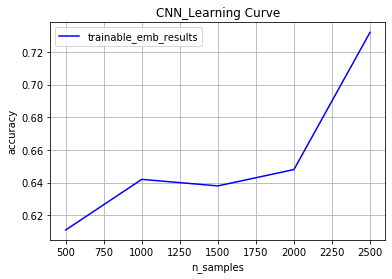

In [18]:
plt.plot(slice_size, trainable_emb_results, color = 'blue', label = 'trainable_emb_results')
plt.xlabel('n_samples')
plt.ylabel('accuracy')
plt.title('CNN_Learning Curve')
plt.grid()
plt.legend();

#### CNN Fixed Embedding _ 2500 Samples

In [11]:
trainable_emb_results = []
train_dataset, test_dataset = add_data_portion(english_dataset, translated_dataset, 2500) # add n_samples from data_2 to data_1

X_train, X_test, embedding_vectors = get_input_plus_embedding_vectors_share_tokenizer(train_dataset, test_dataset, embedding_file_path, 
                                                                                      vocabulary_length, max_length_sequence, emb_dim, language)

print(X_train.shape, X_test.shape, embedding_vectors.shape)

model = create_model(vocabulary_length, max_length_sequence, emb_dim, transfer_learning = True, embedding_vectors = embedding_vectors, 
                     filters = 16, kernel_size = 10, dense_units = 4, l2_kernel = 0)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) # Compile model

Y_train = train_dataset.label.values
model.fit(X_train, Y_train, epochs = epochs, batch_size = batch_size, shuffle = True) # Fit model
Y_test = test_dataset.label.values
loss, acc = model.evaluate(X_test, Y_test)
print(round(acc, 3))

(53733, 1500) (71, 1500) (10000, 300)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/7
53733/53733 [==============================] - 974s 18ms/step - loss: 0.2963 - accuracy: 0.9272
Epoch 2/7
53733/53733 [==============================] - 896s 17ms/step - loss: 0.0861 - accuracy: 0.9662
Epoch 3/7
53733/53733 [==============================] - 729s 14ms/step - loss: 0.0531 - accuracy: 0.9794
Epoch 4/7
53733/53733 [==============================] - 714s 13ms/step - loss: 0.0337 - accuracy: 0.9872
Epoch 5/7
53733/53733 [==============================] - 714s 13ms/step - loss: 0.0223 - accuracy: 0.9916
Epoch 6/7
53733/53733 [==============================] - 724s 13ms/step - loss: 0.0184 - accuracy: 0.9935
Epoch 7/7
71/71 [==============================] - 0s 6ms/step
0.577


#### RNN 2500 Samples - Trainable Embedding

In [14]:
train_dataset, test_dataset = add_data_portion(english_dataset, translated_dataset, 2500) # add 2500 from data_2 to data_1

X_train, X_test, df1, df2 = get_input_share_tokenizer(train_dataset, test_dataset, stemming = False, remove_stopwords = True, 
                                                      vocabulary_length = vocabulary_length, max_length_sequence = max_length_sequence, language = language)
print(X_train.shape, X_test.shape)

model = create_model_RNN(vocabulary_length, max_length_sequence, emb_dim, transfer_learning = False, embedding_vectors = False, 
                             lstm_units = 4, l2_kernel = 0.01, l2_recurrent = 0.01, l2_activity = 0, dropout = 0)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) # Compile model

Y_train = train_dataset.label.values
model.fit(X_train, Y_train, epochs = epochs, batch_size = batch_size, shuffle = True) # Fit model
Y_test = test_dataset.label.values
loss, acc = model.evaluate(X_test, Y_test)
print(round(acc, 3))

(53733, 1500) (71, 1500)
Epoch 1/7
53733/53733 [==============================] - 2642s 49ms/step - loss: 0.2977 - accuracy: 0.9188
Epoch 2/7
53733/53733 [==============================] - 2466s 46ms/step - loss: 0.2052 - accuracy: 0.9289
Epoch 3/7
53733/53733 [==============================] - 2846s 53ms/step - loss: 0.1690 - accuracy: 0.9506
Epoch 4/7
53733/53733 [==============================] - 2229s 41ms/step - loss: 0.1522 - accuracy: 0.9583
Epoch 5/7
53733/53733 [==============================] - 2520s 47ms/step - loss: 0.1295 - accuracy: 0.9666
Epoch 6/7
53733/53733 [==============================] - 4201s 78ms/step - loss: 0.1181 - accuracy: 0.9685
Epoch 7/7
71/71 [==============================] - 2s 25ms/step
0.634


#### RNN  2500 Samples -  Fixed Embedding

In [13]:
train_dataset, test_dataset = add_data_portion(english_dataset, translated_dataset, 2500) # add 2500 from data_2 to data_1

X_train, X_test, embedding_vectors = get_input_plus_embedding_vectors_share_tokenizer(train_dataset, test_dataset, embedding_file_path, 
                                                                                      vocabulary_length, max_length_sequence, emb_dim, language)

print(X_train.shape, X_test.shape, embedding_vectors.shape)

model = create_model_RNN(vocabulary_length, max_length_sequence, emb_dim, transfer_learning = True, embedding_vectors = embedding_vectors, 
                             lstm_units = 8, l2_kernel = 0, l2_recurrent = 0, l2_activity = 0, dropout = 0.5)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) # Compile model

Y_train = train_dataset.label.values
model.fit(X_train, Y_train, epochs = epochs, batch_size = batch_size, shuffle = True) # Fit model
Y_test = test_dataset.label.values
loss, acc = model.evaluate(X_test, Y_test)
print(round(acc, 3))

(53733, 1500) (71, 1500) (10000, 300)
Epoch 1/7
53733/53733 [==============================] - 1709s 32ms/step - loss: 0.3318 - accuracy: 0.8780
Epoch 2/7
53733/53733 [==============================] - 1685s 31ms/step - loss: 0.2259 - accuracy: 0.9159
Epoch 3/7
53733/53733 [==============================] - 1706s 32ms/step - loss: 0.1966 - accuracy: 0.9268
Epoch 4/7
53733/53733 [==============================] - 1645s 31ms/step - loss: 0.1694 - accuracy: 0.9366
Epoch 5/7
53733/53733 [==============================] - 1613s 30ms/step - loss: 0.1501 - accuracy: 0.9446
Epoch 6/7
53733/53733 [==============================] - 1682s 31ms/step - loss: 0.1626 - accuracy: 0.9415
Epoch 7/7
71/71 [==============================] - 1s 19ms/step
0.648
